<a href="https://colab.research.google.com/github/mangohehe/DeepGate2/blob/data-learning/notebooks/DeepGate2-Data%20Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#@markdown Git clone DeepGate2 Repo
!git clone https://github.com/mangohehe/DeepGate2.git

Cloning into 'DeepGate2'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 171 (delta 29), reused 32 (delta 10), pack-reused 86
Receiving objects: 100% (171/171), 55.31 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
#@markdown Run to mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

%cd /content/DeepGate2/data/train
%pwd

Mounted at /content/drive
/content/DeepGate2/data/train


'/content/DeepGate2/data/train'

In [ ]:
#@markdown Run to unzip training data

%cd /content/DeepGate2/dataset
!tar -jxvf rawaig.tar.bz2

In [5]:
import os
from collections import defaultdict
import pandas as pd
# Import the data_table module
from google.colab import data_table
from collections import defaultdict, Counter
# Enable the DataTable formatter globally
data_table.enable_dataframe_formatter()

RAW_AIG_DIR = "/content/DeepGate2/dataset/rawaig" #@param

# Background

**Data Representation:**

* **x_data:** A list of lists where each inner list represents a node in the circuit. Example: `[[node_name, gate_type, logic_level, C1, C0, Obs], ...]`
* **edge_index_data:** A list of lists where each inner list represents an edge (connection) in the circuit. Example: `[[source_node_index, target_node_index], ...]`
* **level_list:** A list of lists where each sublist contains the indices of nodes belonging to the same logic level.
* **fanin_list:** A list of lists where each inner list contains the indices of fan-in nodes for a corresponding node.
* **fanout_list:** A list of lists where each inner list contains the indices of fan-out nodes for a corresponding node.

**Data Processing Flow**

1. **Circuit Data Loading:** The code starts by reading circuit data from a file (likely a .bench file) using `read_file`.
2. **Preprocessing:** The loaded data likely undergoes preprocessing to extract relevant features, add node indices, and generate necessary data structures (`x_data`, `edge_index_data`, etc.).
3. **Controllability/Observability Analysis:** Controllability (C1, C0) and observability (Obs) values may be calculated for nodes.
4. **Circuit Simulation:** The `simulator` function performs the main simulation loop:
   * Generates random input patterns.
   * Propagates values through the circuit based on gate logic.
   * Updates C1 values based on simulation results.
5. **Analysis:** Functions might be used to identify reconvergent nodes and gather circuit statistics.


# Load .bench files

In [6]:
#@markdown def load_combined_bench_files_for_curcuits(bench_dir)

def load_combined_bench_files_for_curcuits(bench_dir):
    """Analyze .bench files in the specified directory and return a summary DataFrame."""

    # Initialize a defaultdict to store counts for each circuit
    circuit_data = defaultdict(lambda: {
        'Number of Files': 0, 'Inputs': 0, 'Outputs': 0, 'AND': 0, 'NOT': 0, 'OR': 0,
        'NAND': 0, 'NOR': 0, 'XOR': 0, 'XNOR': 0, 'Others': Counter(), 'Total Gates': 0
    })

    # Check if the directory exists before proceeding
    if not os.path.exists(bench_dir) or not os.path.isdir(bench_dir):
        print(f"Directory {bench_dir} not found or isn't a directory.")
        return pd.DataFrame()

    # Initialize a global counter for unknown instance types
    global_unknown_types = Counter()

    # Iterate through the files in the directory
    for filename in os.listdir(bench_dir):
        # Process only files ending with the .bench extension
        if filename.endswith(".bench"):
            circuit_name = '_'.join(filename.split('_')[:-1])
            circuit_data[circuit_name]['Number of Files'] += 1

            # Initialize counters for gates and pins
            inputs = outputs = and_gates = not_gates = or_gates = nand_gates = nor_gates = xor_gates = xnor_gates = 0
            unknown_types = Counter()

            # Open and parse the .bench file
            file_path = os.path.join(bench_dir, filename)
            try:
                with open(file_path, "r") as f:
                    for line in f:
                        line = line.strip()
                        if line.startswith("INPUT"):
                            inputs += 1
                        elif line.startswith("OUTPUT"):
                            outputs += 1
                        elif "= AND" in line:
                            and_gates += 1
                        elif "= NOT" in line:
                            not_gates += 1
                        elif "= OR" in line:
                            or_gates += 1
                        elif "= NAND" in line:
                            nand_gates += 1
                        elif "= NOR" in line:
                            nor_gates += 1
                        elif "= XOR" in line:
                            xor_gates += 1
                        elif "= XNOR" in line:
                            xnor_gates += 1
                        else:
                            if "=" in line:
                                gate_type = line.split('=')[1].strip().split()[0]
                                unknown_types[gate_type] += 1

                # Aggregate known gate counts
                circuit_data[circuit_name]['Inputs'] += inputs
                circuit_data[circuit_name]['Outputs'] += outputs
                circuit_data[circuit_name]['AND'] += and_gates
                circuit_data[circuit_name]['NOT'] += not_gates
                circuit_data[circuit_name]['OR'] += or_gates
                circuit_data[circuit_name]['NAND'] += nand_gates
                circuit_data[circuit_name]['NOR'] += nor_gates
                circuit_data[circuit_name]['XOR'] += xor_gates
                circuit_data[circuit_name]['XNOR'] += xnor_gates
                circuit_data[circuit_name]['Others'].update(unknown_types)

                # Sum all gates excluding inputs and outputs
                total_gates = (
                    and_gates + not_gates + or_gates + nand_gates +
                    nor_gates + xor_gates + xnor_gates + sum(unknown_types.values())
                )
                circuit_data[circuit_name]['Total Gates'] += total_gates

                # Update the global unknown types counter
                global_unknown_types.update(unknown_types)

            except IOError as e:
                print(f"Error reading file {filename}: {e}")

    # Convert to DataFrame and handle the Others column as a string
    df = pd.DataFrame.from_dict(circuit_data, orient='index')
    df['Others'] = df['Others'].apply(dict)

    # Add a total summary row
    df.loc['Total'] = df.sum(numeric_only=True)
    df.at['Total', 'Number of Files'] = df['Number of Files'].sum()
    df.at['Total', 'Others'] = dict(global_unknown_types)
    df.index.name = 'Circuit'
    df['Circuit'] = df.index
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.reset_index(drop=True)
    # Log all unknown gate types globally
    print("Global unknown gate types across all circuits:", dict(global_unknown_types))

    return df

import os
from collections import defaultdict
import fnmatch

#@markdown def analyze_a_circuit_bench_files(bench_dir, pattern="log2.*.bench")

def analyze_single_circuit_bench_files(bench_dir, pattern="log2.*.bench"):
    """Analyze fan-in and fan-out for .bench files matching the given pattern."""
    fanin_counts = defaultdict(int)
    fanout_graph = defaultdict(list)

    # Check if the directory exists
    if not os.path.exists(bench_dir) or not os.path.isdir(bench_dir):
        print(f"Directory {bench_dir} not found or isn't a directory.")
        return None

    # Iterate through each file in the directory
    for filename in os.listdir(bench_dir):
        if fnmatch.fnmatch(filename, pattern):
            file_path = os.path.join(bench_dir, filename)

            try:
                with open(file_path, "r") as f:
                    for line in f:
                        line = line.strip()
                        if "=" in line:
                            # Parse the gate and its input connections
                            print(line)
                            gate, expression = line.split("=")
                            gate = gate.strip()
                            inputs = expression.strip().split(",")
                            fanin_counts[gate] = len(inputs)
                            for input_gate in inputs:
                                input_gate = input_gate.strip()
                                fanout_graph[input_gate].append(gate)

            except IOError as e:
                print(f"Error reading file {filename}: {e}")

    # Calculate fan-in and fan-out values
    fanin_values = list(fanin_counts.values())
    fanout_counts = {k: len(v) for k, v in fanout_graph.items()}
    fanout_values = list(fanout_counts.values())

    # Summary statistics
    avg_fanin = sum(fanin_values) / len(fanin_values) if fanin_values else 0
    avg_fanout = sum(fanout_values) / len(fanout_values) if fanout_values else 0

    print(f"Average Fan-In: {avg_fanin:.2f}")
    print(f"Average Fan-Out: {avg_fanout:.2f}")

    return {
        "fanin_counts": fanin_counts,
        "fanout_counts": fanout_counts,
        "avg_fanin": avg_fanin,
        "avg_fanout": avg_fanout
    }



In [7]:
#@markdown Run to load bench files to a DF
df_bench = load_combined_bench_files_for_curcuits(RAW_AIG_DIR)
df_bench.head(20)

Global unknown gate types across all circuits: {}


,Number of Files,Inputs,Outputs,AND,NOT,Others,Total Gates,Circuit
0,653.0,47359.0,4144.0,78469.0,80196.0,{},158665.0,mem_ctrl_syn
1,308.0,22605.0,4848.0,42764.0,51655.0,{},94419.0,b18_opt_C
2,474.0,31709.0,3484.0,87147.0,89663.0,{},176810.0,reed_solomon_codec_generator_syn
3,690.0,41223.0,1766.0,80256.0,65185.0,{},145441.0,vga_lcd_syn
4,23.0,873.0,99.0,1868.0,2623.0,{},4491.0,i2c_syn
5,20.0,296.0,54.0,2464.0,1590.0,{},4054.0,fast_antilog_syn
6,977.0,18678.0,14706.0,98741.0,45760.0,{},144501.0,logicProbe_syn
7,108.0,6198.0,1127.0,16305.0,20011.0,{},36316.0,aes_core_syn
8,90.0,6253.0,677.0,9589.0,10761.0,{},20350.0,s38584_syn
9,295.0,27597.0,1790.0,112717.0,139608.0,{},252325.0,multiplier_syn


# Explore a partial circuit


In [8]:
#@markdown Find a circuit

Circuit_Name = 'log2_syn' #@param

df_bench[df_bench['Circuit'] == Circuit_Name]


,Number of Files,Inputs,Outputs,AND,NOT,Others,Total Gates,Circuit
26,336.0,29689.0,1463.0,130826.0,159275.0,{},290101.0,log2_syn


In [9]:
#@markdown Install Python library
!pip install graphviz

In [10]:
#@markdown Explore a partial circuit

from IPython.display import display, Image

bench_index = "010" #@param
print(Circuit_Name)

bench_file=RAW_AIG_DIR + "/{Circuit_Name}_{Number_of_files}.bench".format(Circuit_Name=Circuit_Name, Number_of_files=bench_index)



log2_syn


# Circuit Analysis Methods

This notebook contains a suite of functions for parsing, analyzing, and visualizing circuit descriptions in `.bench` format. Here's a breakdown of the key methods and their purposes:

**1. `parse_bench(file_path)`**

* Reads a `.bench` file containing a circuit description.
* Extracts the input nodes, output nodes, and gate definitions (including the connections between them).
* Organizes the parsed information into a dictionary of gates (with input lists), a list of inputs, and a list of outputs.

**2. `compute_levels(graph, inputs)`**

* Takes a graph representation of the circuit and the list of input nodes.
* Performs a breadth-first search to determine the level (distance from input nodes) of each node in the circuit.
* Returns a dictionary containing node levels and the computed degree centrality of each node.

**3. `critical_path(graph, levels, centrality)`**

* Leverages the level information to identify the critical path – the longest sequence of connected nodes in the circuit. This path represents a potential timing bottleneck.
* Determines high-centrality nodes, which have the largest number of connections and are often crucial for circuit function.
* Returns the critical path, the maximum level, and a list of high-centrality nodes.

**4. `create_graphviz_graph(gates, inputs, outputs)`**

 * Constructs a visual representation of the circuit using the Graphviz library.
 * Nodes represent input, output, and gate components.
 * Employs distinct colors and styles to visually highlight critical path nodes and high-centrality nodes for quick analysis.

**5. `gate_utilization(gates)`**

* Analyzes the parsed gate information to determine the frequency of different gate types (e.g., AND, NOT, OR) used within the circuit design.
* Returns a dictionary summarizing the utilization of each gate type.

**6. `analyze_circuit(file_path)`**

* The primary function that orchestrates the entire analysis process.
* Parses the circuit description from the `.bench` file.
* Generates a Graphviz visualization of the circuit.
* Calculates key summary statistics, including the number of inputs, outputs, and gates.
* Displays the graph visualization and a summary table, providing a comprehensive overview of the circuit's structure.

In [11]:
import os
import re
from collections import defaultdict, deque
from graphviz import Digraph
from graphviz import Digraph
import networkx as nx
from collections import deque
from IPython.display import Image, display, HTML
import numpy as np

#@markdown def parse_bench(file_path)

def parse_bench(file_path):
    """Parses a bench file into gates, inputs, and outputs.

    Args:
        file_path (str): Path to the .bench file.

    Returns:
        tuple: A tuple containing:
            * gates (dict): A dictionary mapping gate IDs to lists of input IDs.
            * inputs (list): A list of input IDs.
            * outputs (list): A list of output IDs.
    """
    gates = {}
    inputs = []
    outputs = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('#') or not line:
                continue
            elif line.startswith('INPUT'):
                input_gate = re.findall(r'\((.*?)\)', line)[0]
                inputs.append(input_gate)
            elif line.startswith('OUTPUT'):
                output_gate = re.findall(r'\((.*?)\)', line)[0]
                outputs.append(output_gate)
            elif '=' in line:
                left, right = line.split('=')
                gate = left.strip()
                expression = right.strip().split('(')[1].split(')')[0]
                inputs_list = [inp.strip() for inp in expression.split(',')]
                gates[gate] = inputs_list

    return gates, inputs, outputs

#@markdown def compute_levels(graph, inputs)
def compute_levels(graph, inputs):
    """ Compute levels of each node in the graph starting from inputs. """
    levels = {}
    queue = deque([(input_node, 0) for input_node in inputs])
    while queue:
        node, level = queue.popleft()
        if node in levels and levels[node] >= level:
            continue
        levels[node] = level
        for successor in graph.successors(node):
            queue.append((successor, level + 1))

    # Calculate degree centrality
    centrality = nx.degree_centrality(graph)
    return levels, centrality

#@markdown def critical_path(graph, levels, centrality)
def critical_path(graph, levels, centrality):
    """ Identify the longest path in the graph based on levels. """
    max_level = max(levels.values())
    critical_nodes = [node for node, level in levels.items() if level == max_level]

    # Identify high-centrality nodes (e.g., top 25%)
    threshold = np.percentile(list(centrality.values()), 90)
    high_centrality_nodes = [node for node, cent in centrality.items() if cent >= threshold]

    return nx.dag_longest_path(graph, weight=None), max_level, high_centrality_nodes

#@markdown def create_graphviz_graph(gates, inputs, outputs)
def create_graphviz_graph(gates, inputs, outputs):
    """Creates a Graphviz representation of a circuit.

    Args:
        gates (dict): A dictionary mapping gate IDs to lists of input IDs.
        inputs (list): A list of input IDs.
        outputs (list): A list of output IDs.

    Returns:
        Digraph: A Graphviz Digraph object representing the circuit.
    """
    graph = nx.DiGraph()
    for gate, inp_list in gates.items():
        for inp in inp_list:
            graph.add_edge(inp, gate)
    for out in outputs:
        if out in gates:
            for inp in gates[out]:
                graph.add_edge(inp, out)

    # Compute levels and find the critical path
    levels, centrality = compute_levels(graph, inputs)
    critical_path_nodes, _, high_centrality_nodes = critical_path(graph, levels, centrality)

    dot = Digraph(comment='Circuit Diagram')
    # Create nodes
    for node in graph.nodes():
        if node in inputs:
            style = 'filled' if node in critical_path_nodes else ''
            dot.node(node, label=f'Input {node}', shape='circle', style=style, color='lightblue')
        elif node in outputs:
            style = 'filled' if node in critical_path_nodes else ''
            dot.node(node, label=f'Output {node}', shape='doublecircle', style=style, color='lightcoral')
        else:
            # Prioritize critical path (yellow) over high centrality (blue)
            color = 'red' if node in critical_path_nodes else (
                'blue' if node in high_centrality_nodes else '')
            style = 'filled' if color != '' else ''  # Fill only for colored nodes
            dot.node(node, label=f'Gate {node}', style=style, color=color)

    # Create edges
    for input_gate, gate in graph.edges():
        edge_color = 'red' if input_gate in critical_path_nodes and gate in critical_path_nodes else 'black'
        dot.edge(input_gate, gate, color=edge_color)

    return dot

#@markdown def gate_utilization(gates)
def gate_utilization(gates):
    """ Count occurrences of each gate type. """
    counts = defaultdict(int)
    for inputs in gates.values():
        for gate in inputs:
            if gate in gates:  # Ensure to count only gate types
                gate_type = gate.split('(')[0]
                counts[gate_type] += 1
    return dict(counts)

#@markdown def analyze_circuit(file_path)
def analyze_circuit(file_path):
    """Parses a circuit, generates a graph, and displays a summary.

    Args:
        file_path (str): Path to the .bench file.
    """
    gates, inputs, outputs = parse_bench(bench_file)

    # Generate the graph and render it to a PNG file
    dot = create_graphviz_graph(gates, inputs, outputs)
    dot.format = 'png'
    dot.render('/content/output_graph', view=False)

    # Count inputs, outputs, and gates
    num_inputs = len(inputs)
    num_outputs = len(outputs)
    num_gates = len(gates)

    # Create summary table
    data = {
        'Component Type':  ['Inputs', 'Outputs', 'Gates'],
        'Count': [num_inputs, num_outputs, num_gates]
    }
    df = pd.DataFrame(data)

    display(HTML(df.to_html(index=False, border=1)))
    # Display the PNG in the notebook
    display(Image('/content/output_graph.png'))


### Run to generate a visual representation of a circuit using Graphviz. It depicts various components like inputs, outputs, and gates with different colors:

*  Inputs are light blue by default, but highlighted blue if they have high
centrality.

*  Outputs are light coral by default, highlighted similarly if they have high centrality.

*  Gates are colored red if they are on the critical path, or blue if they have high centrality. Gates not on the critical path or not highly central are left uncolored.


Component Type,Count
Inputs,60
Outputs,1
Gates,512


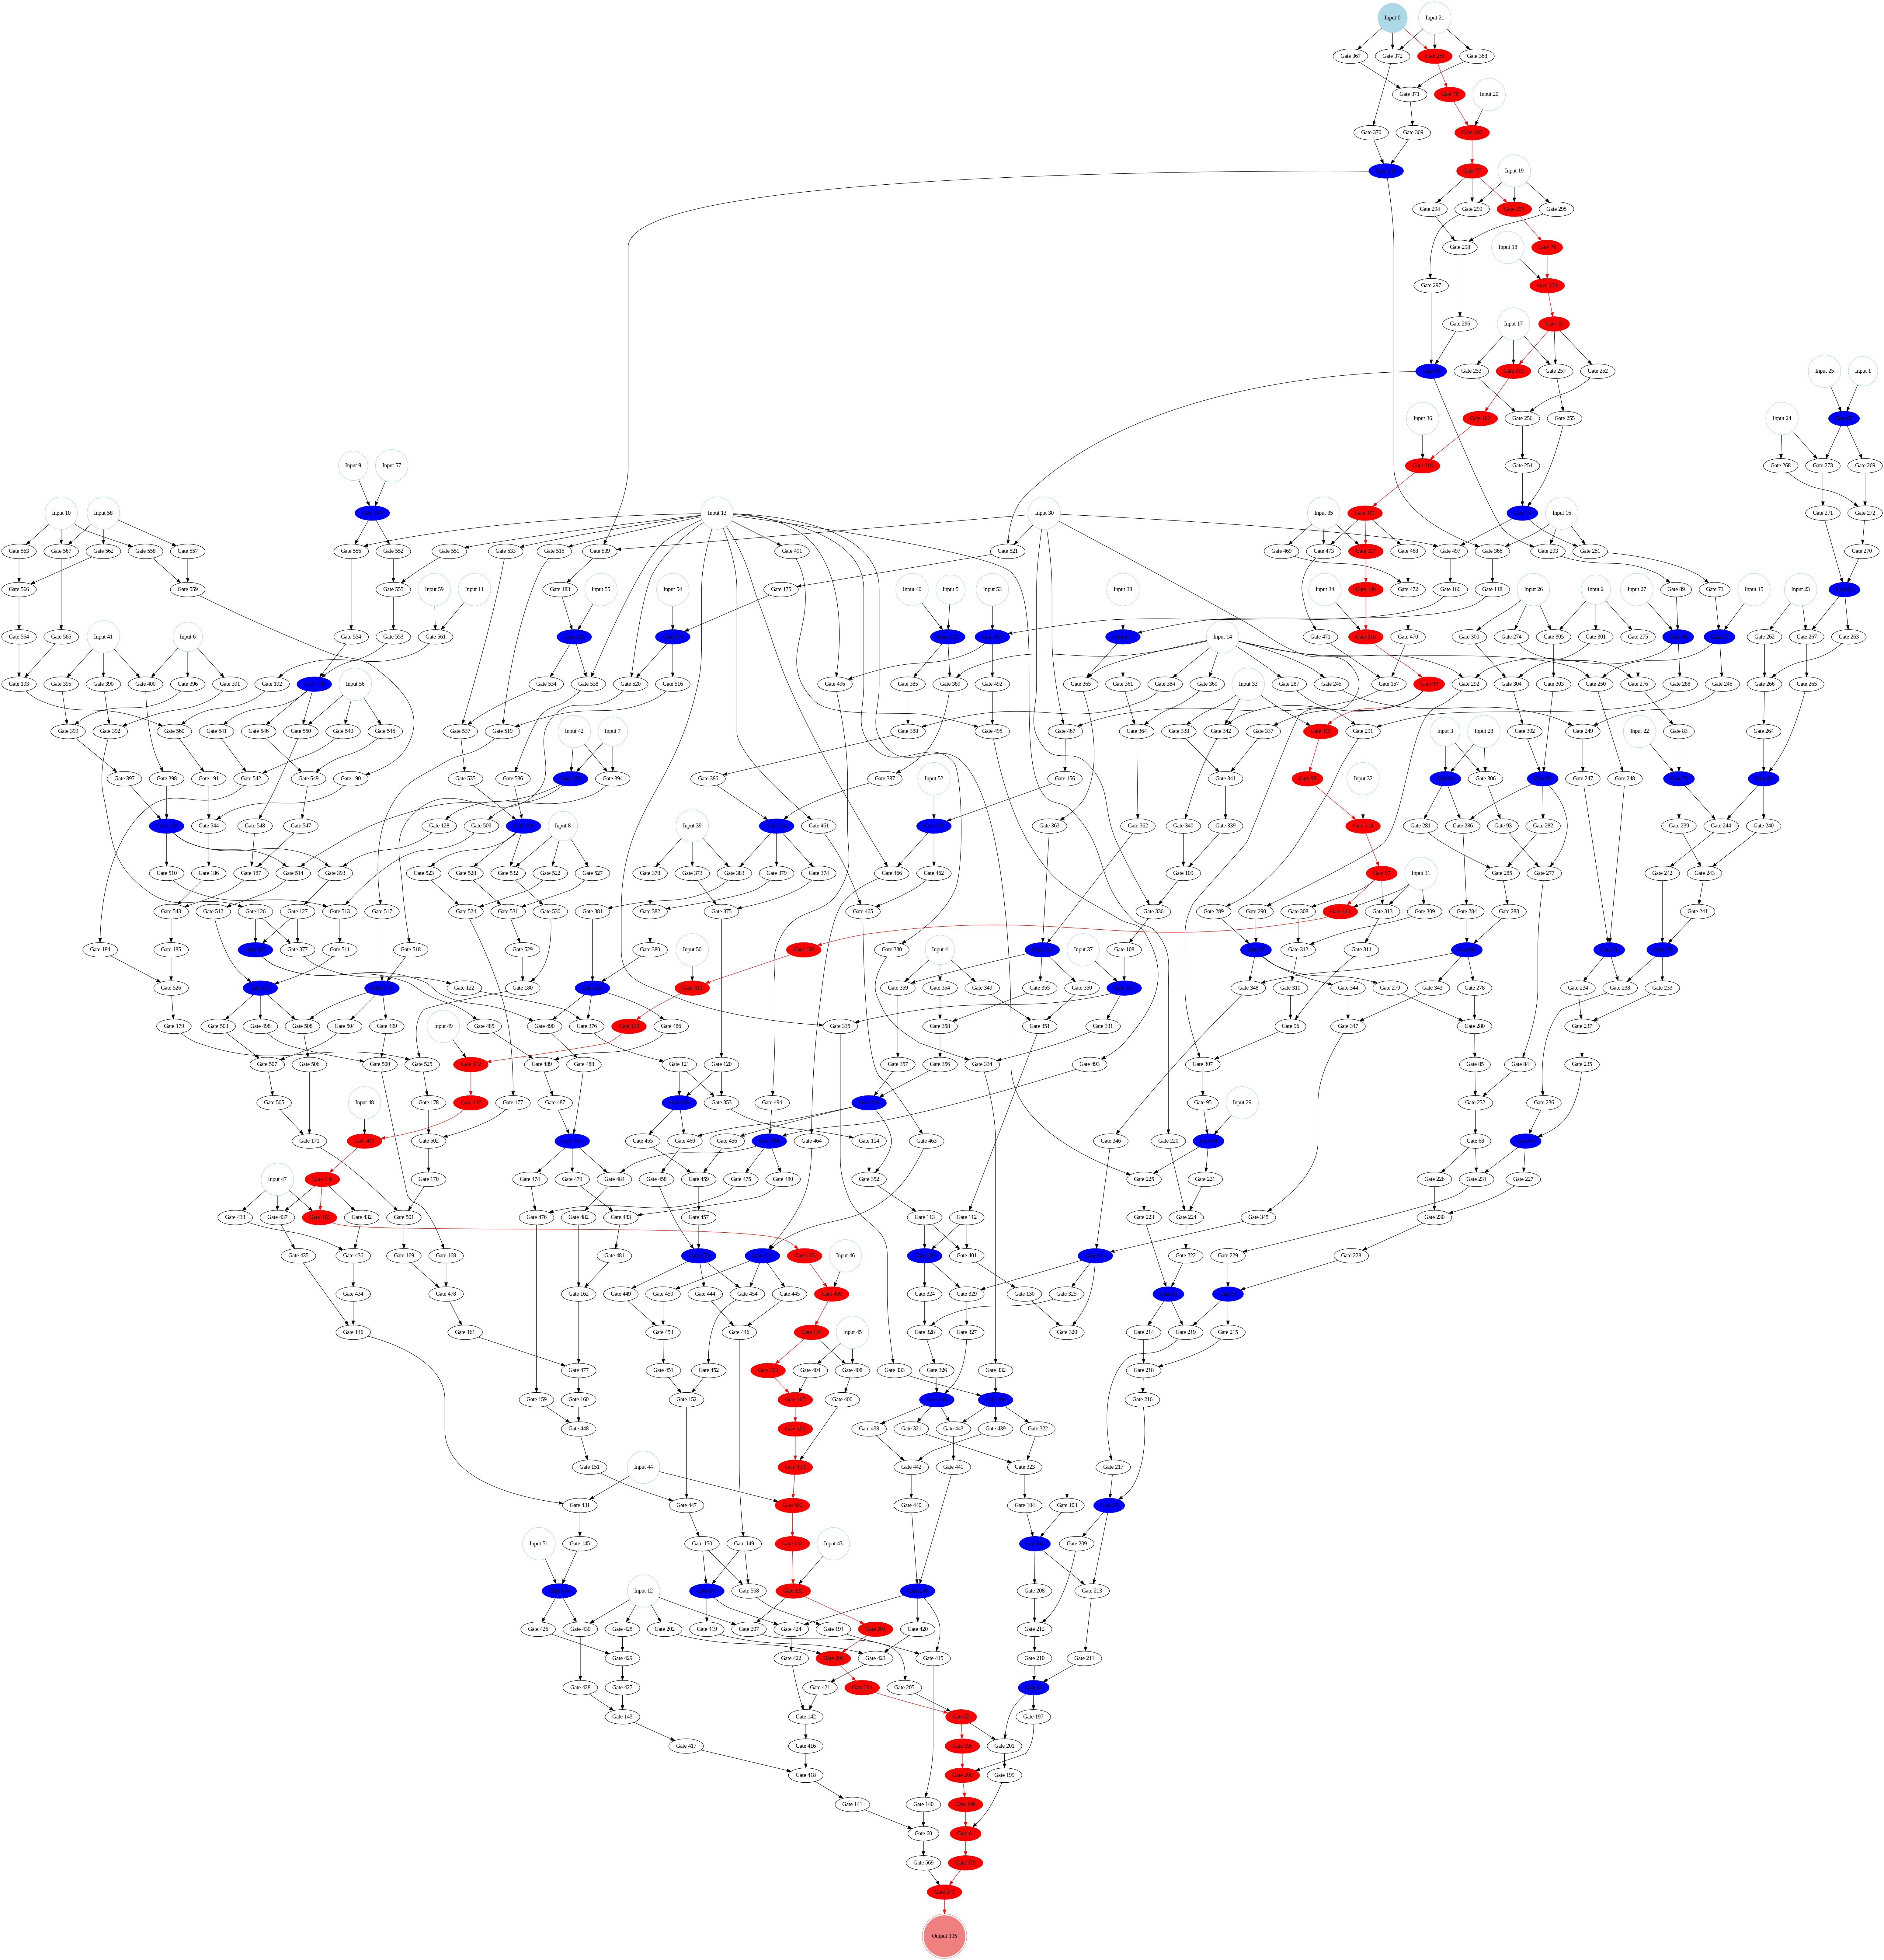

In [12]:
analyze_circuit(bench_file)

# Load NPZ files

In [13]:
#@markdown Npz files directories

import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/DeepGate2/train.zip' #@param
train_train_data_dir = '/content/DeepGate2/data/train' #@param
train_data_dir = '/content/DeepGate2/data' #@param

# Remove the folder if it exists
if os.path.exists(train_train_data_dir):
    !rm -rf {train_train_data_dir}

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_data_dir)

# Replace these file paths with the actual paths to your `.npz` files
graphs_npz_file = "{train_train_data_dir}/graphs.npz".format(train_train_data_dir = train_train_data_dir)
labels_npz_file = "{train_train_data_dir}/labels.npz".format(train_train_data_dir = train_train_data_dir)

print("Graph Npz File: ", graphs_npz_file)
print("Labels Npz File: ", labels_npz_file)


Graph Npz File:  /content/DeepGate2/data/train/graphs.npz
Labels Npz File:  /content/DeepGate2/data/train/labels.npz


In [14]:
#@markdown Load pre-generated npz files

import numpy as np
import pandas as pd

# Load the .npz file (replace with your file path)
graph_npz_file = np.load(graphs_npz_file, allow_pickle=True)

# Access the 'circuits' data
circuits_data = graph_npz_file['circuits'].item()

def summarize_structure(data):
    """Analyzes the structure and provides summary information."""

    summary_data = []

    if isinstance(data, np.ndarray):
        summary_data.append({
            'Key': 'NumPy Array',
            'Type': 'Array',
            'Shape': data.shape,
            'Data Type': data.dtype
        })

    elif isinstance(data, dict):
        summary_data.append({
            'Num. of Circuits': len(data)
        })

    return summary_data

# Analyze and summarize
summary_data = summarize_structure(circuits_data)

# Create DataFrame and display table
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


 Num. of Circuits
            10000


In [16]:
#@markdown Find the circuit named Circuit_Name_Bench_Index
circuit_name = Circuit_Name+'_'+bench_index

circuit_data = circuits_data.get(circuit_name)

if circuit_data is not None:
    print("Found circuit data for 'Circuit_Name': {circuit_name}".format(circuit_name=circuit_name))
    print(f"Number of Nodes: {circuit_data['x'].shape[0]}")
    print(f"Number of Edges: {circuit_data['edge_index'].shape[0]}")
else:
    print("Circuit named 'Circuit_Name' not found in the data.")

Found circuit data for 'Circuit_Name': log2_syn_010
Number of Nodes: 572
Number of Edges: 742


In [17]:

import numpy as np
import pandas as pd
#@markdown Load {graphs, labels} to DF

#@markdown def load_npz_data_to_df(bench_dir, pattern="log2.*.bench")

def load_npz_data_to_df(graphs_file, labels_file):
    """Load and convert the circuit data into a DataFrame."""

    # Load graph data
    graph_data = np.load(graphs_file, allow_pickle=True)
    label_data = np.load(labels_file, allow_pickle=True)

    # Extract graph circuits and label data
    circuits = graph_data['circuits'].item()
    labels = label_data['labels'].item()

    # Create a list to store circuit information
    circuit_info = []

    # Iterate over circuits and gather details
    for circuit_name, graph_info in circuits.items():
        x = graph_info['x']  # Node feature matrix
        edge_index = graph_info['edge_index']  # Edge index matrix

        circuit_labels = labels[circuit_name]
        tt_pair_index = circuit_labels['tt_pair_index']  # Index pairs for truth table comparison
        tt_dis = circuit_labels['tt_dis']  # Truth table distances

        # Gather circuit data into a dictionary
        circuit_info.append({
            'Circuit Name': circuit_name,
            'Number of Nodes': x.shape[0],
            'Number of Edges': edge_index.shape[0],
            'Number of TT Pairs': tt_pair_index.shape[0],
            'Number of TT Distances': tt_dis.shape[0]
        })

    # Convert to a DataFrame

    df = pd.DataFrame(circuit_info)

    return df

circuit_df = load_npz_data_to_df(graphs_npz_file, labels_npz_file)
circuit_df.describe()

,Number of Nodes,Number of Edges,Number of TT Pairs,Number of TT Distances
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,347.039700,442.745600,87.843300,87.843300
std,311.082826,413.338462,283.730719,283.730719
min,18.000000,19.000000,0.000000,0.000000
25%,167.000000,247.000000,24.000000,24.000000
50%,257.000000,306.000000,44.000000,44.000000
75%,403.000000,497.000000,82.000000,82.000000
max,3676.000000,5006.000000,11938.000000,11938.000000
